<a href="https://colab.research.google.com/github/lua1235/TornML/blob/main/Testbed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Get Dataset From Google Sheets


In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('Torn ML DataSet').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get('J2:CX')
rows[1:] = [[np.float64(i) for i in r] for r in rows[1:]]

view = pd.DataFrame(rows[1:], columns=rows[0])

# normalize
lMean = view['Stat Totals'].mean()
lStd = view['Stat Totals'].std()

fMean = view[view.columns[1:]].mean()
fMean = view[view.columns[1:]].std()

view = (view - view.mean())/view.std()
view = view.sample(frac=1, random_state=1)
labels = view['Stat Totals'].to_numpy()
features = view[view.columns[1:]].to_numpy()
print(view.shape)
print(labels.shape)
print(features.shape)

features = np.append(np.ones((len(features), 1)), features, 1) # append a column of 1s for bias term



(178, 93)
(178,)
(178, 92)


# Learners
Using squared loss

##Batch ERM

In [13]:
# X - (n, d+1) matrix of features
# Y - (n, 1) vector of labels

def batch_erm_learner(X, y, step_function, random_seed = 1, epochs = 10) :
  n, d = np.shape(X)
  w = np.random.default_rng(random_seed).random(d) # random weight initialization

  for i in range(epochs) :
    gradient = (2/n) * (X.T @ (X @ w - y))
    w = w - step_function(i) * gradient

  # x - (d, 1) vector of features
  def predictor(x) :
    return x @ w

  return predictor, w

## Batch ERM With Regularization

In [4]:
# X - (n, d+1) matrix of features
# Y - (n, 1) vector of labels

def batch_reg_learner(X, y, step_function, _lambda = 0.01, random_seed = 1, epochs = 10) :
  n, d = np.shape(X)
  w = np.random.default_rng(random_seed).random(d) # random weight initialization

  for i in range(epochs) :
    loss_gradient = (2/n) * (X.T @ (X @ w - y))
    regu_gradient = (2*_lambda/n) * w
    w = w - step_function(i) * (loss_gradient + regu_gradient)

  # x - (d, 1) vector of features
  def predictor(x) :
    return x @ w

  return predictor, w

#Training and Testing

## Dataset splitting

In [5]:
# split the dataset into training and testing set
n = len(features)
train_features = features[:(n + 1) // 2]
train_labels = labels[:(n + 1) // 2]
train_n = len(train_features)

test_features = features[(n + 1) // 2:]
test_labels = labels[(n + 1) // 2:]
test_n = len(train_features)

def loss(a) :
    return 0.01


##Lambda Tests For Regularization

         Lambda  training error  testing error
0  1.000000e-10        0.023724      17.847790
1  1.000000e-09        0.023724      17.847790
2  1.000000e-08        0.023724      17.847790
3  1.000000e-07        0.023724      17.847789
4  1.000000e-06        0.023724      17.847782
5  1.000000e-05        0.023724      17.847714
6  1.000000e-04        0.023723      17.847027
7  1.000000e-03        0.023716      17.840164
8  1.000000e-02        0.023637      17.771679
9  1.000000e-01        0.022866      17.101531


<Axes: xlabel='Lambda'>

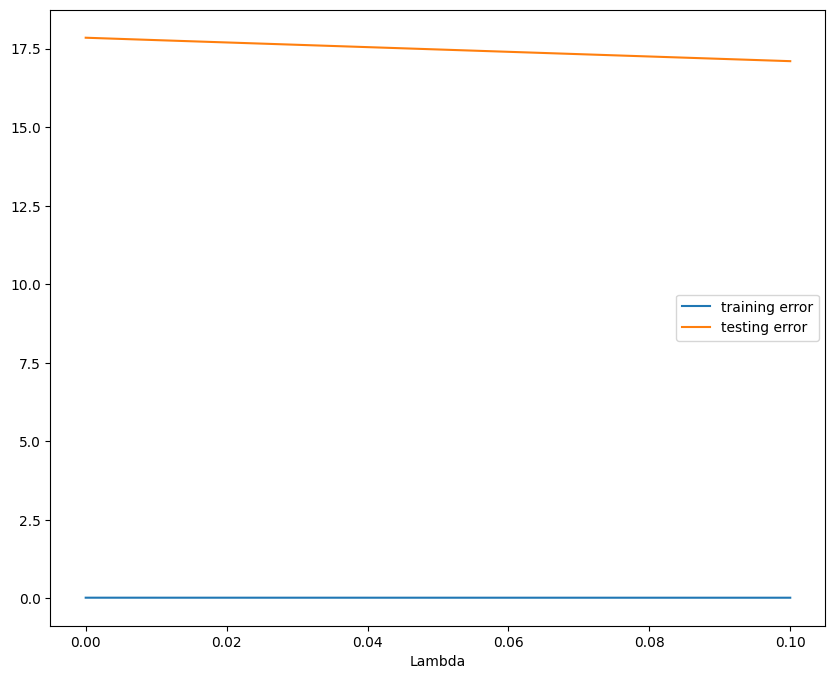

In [11]:
errors = {'Lambda' : [], 'training error' : [], 'testing error' : []}

for i in range(10, 0, -1) :
  reg_f, reg_w = batch_reg_learner(train_features, train_labels, loss, _lambda = 1/(10**i), epochs = 1000)
  #print(batch_erm_w)
  #print(batch_erm_f(train_features[0]))
  train_error = (1/train_n) * sum([(reg_f(x) - y) ** 2 for x, y in zip(train_features, train_labels)])
  test_error = (1/test_n) * sum([(reg_f(x) - y) ** 2 for x, y in zip(test_features, test_labels)])
  errors['Lambda'].append(1/(10**i))
  errors['training error'].append(train_error)
  errors['testing error'].append(test_error)

errors = pd.DataFrame(errors)
print(errors)
errors.plot(figsize=(10, 8), x='Lambda', y=['training error', 'testing error'])


## Epoch Comparision

    epochs  batch training error  batch testing error  reg training error  \
0        0            376.185007          1167.729910          376.185007   
1      100              0.322962            34.978393            0.308605   
2      200              0.145079            30.329252            0.133407   
3      300              0.088461            27.367084            0.078670   
4      400              0.063334            25.154421            0.054552   
..     ...                   ...                  ...                 ...   
95    9500              0.003301             4.483675            0.002141   
96    9600              0.003267             4.437027            0.002142   
97    9700              0.003234             4.391042            0.002142   
98    9800              0.003202             4.345708            0.002142   
99    9900              0.003170             4.301013            0.002142   

    reg testing error  
0         1167.729910  
1           33.483316  
2  

<Axes: xlabel='epochs'>

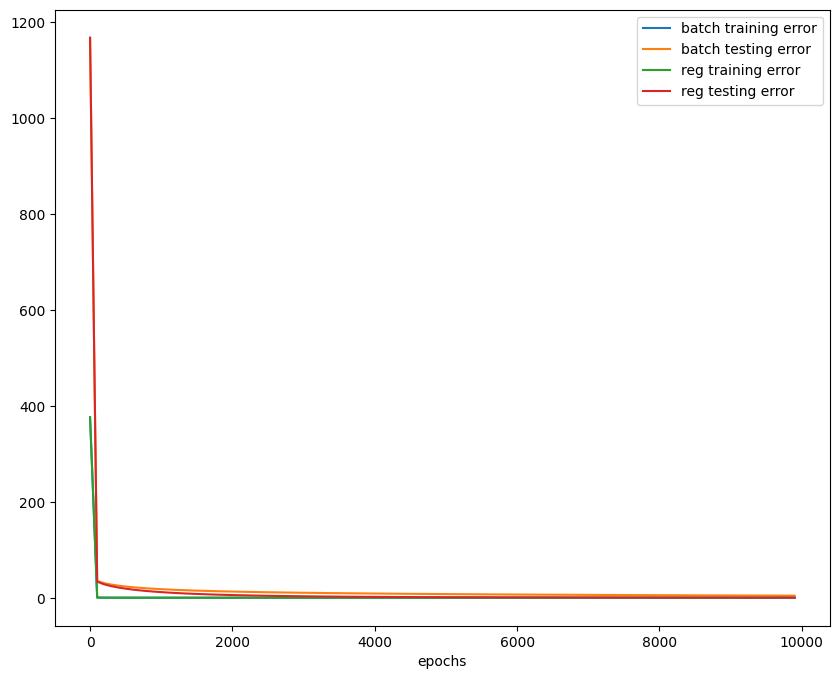

In [14]:
errors = {'epochs' : [],
          'batch training error' : [],
          'batch testing error' : [],
          'reg training error' : [],
          'reg testing error' : []}

for i in range(0, 10000, 100) :
  batch_erm_f, batch_erm_w = batch_erm_learner(train_features, train_labels, loss, epochs = i)
  reg_f, reg_w = batch_reg_learner(train_features, train_labels, loss, _lambda = 1, epochs = i)
  #print(batch_erm_w)
  #print(batch_erm_f(train_features[0]))
  btrain_error = (1/train_n) * sum([(batch_erm_f(x) - y) ** 2 for x, y in zip(train_features, train_labels)])
  btest_error = (1/test_n) * sum([(batch_erm_f(x) - y) ** 2 for x, y in zip(test_features, test_labels)])
  rtrain_error = (1/train_n) * sum([(reg_f(x) - y) ** 2 for x, y in zip(train_features, train_labels)])
  rtest_error = (1/test_n) * sum([(reg_f(x) - y) ** 2 for x, y in zip(test_features, test_labels)])
  errors['epochs'].append(i)
  errors['batch training error'].append(btrain_error)
  errors['batch testing error'].append(btest_error)
  errors['reg training error'].append(rtrain_error)
  errors['reg testing error'].append(rtest_error)

errors = pd.DataFrame(errors)
print(errors)
errors.plot(figsize=(10, 8), x='epochs', y=['batch training error', 'batch testing error', 'reg training error', 'reg testing error'])




# Denormalized Results

    index  Actual Stat Total  Predicted Stat Total  Reg Predicted Stat Total
0       0       9.609889e+08         -3.341858e+08              5.299796e+08
1       1       6.499490e+05         -2.499546e+08             -3.777516e+08
2       2       4.829629e+09          4.057439e+09              4.734505e+09
3       3       6.415788e+08          1.282162e+09              7.688485e+08
4       4       1.596845e+07          5.846470e+08              3.324513e+08
..    ...                ...                   ...                       ...
84     84       2.298723e+09          2.834487e+09              2.297815e+09
85     85       1.425287e+09          1.003845e+09              9.342091e+08
86     86       1.281295e+08          6.289471e+08              4.134344e+08
87     87       1.500085e+09          9.570039e+08              8.865424e+08
88     88       3.848671e+06          1.591528e+08              1.724485e+08

[89 rows x 4 columns]
    index  Actual Stat Total  Predicted Stat Total  R

<Axes: title={'center': 'Train Error'}, xlabel='index'>

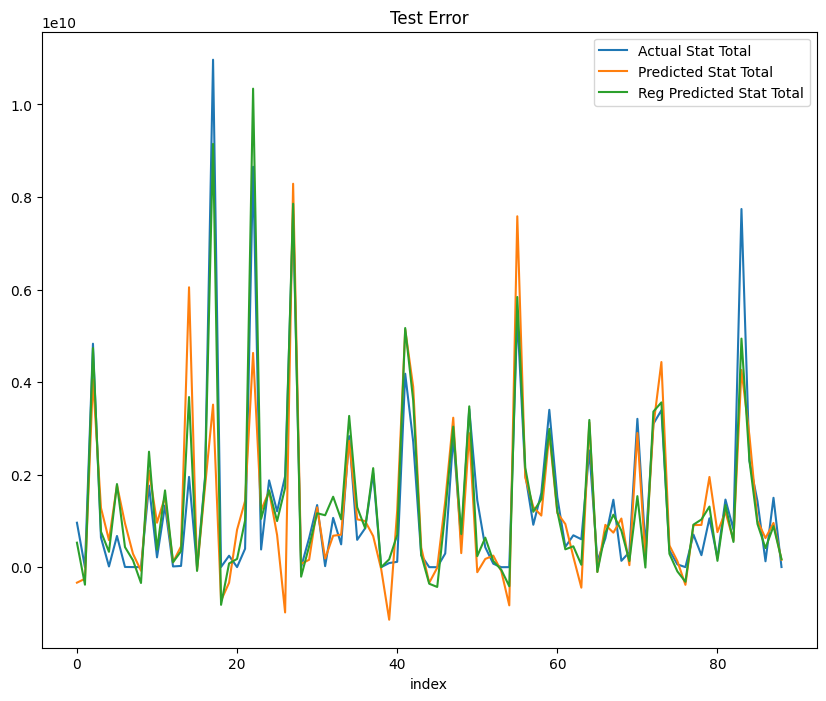

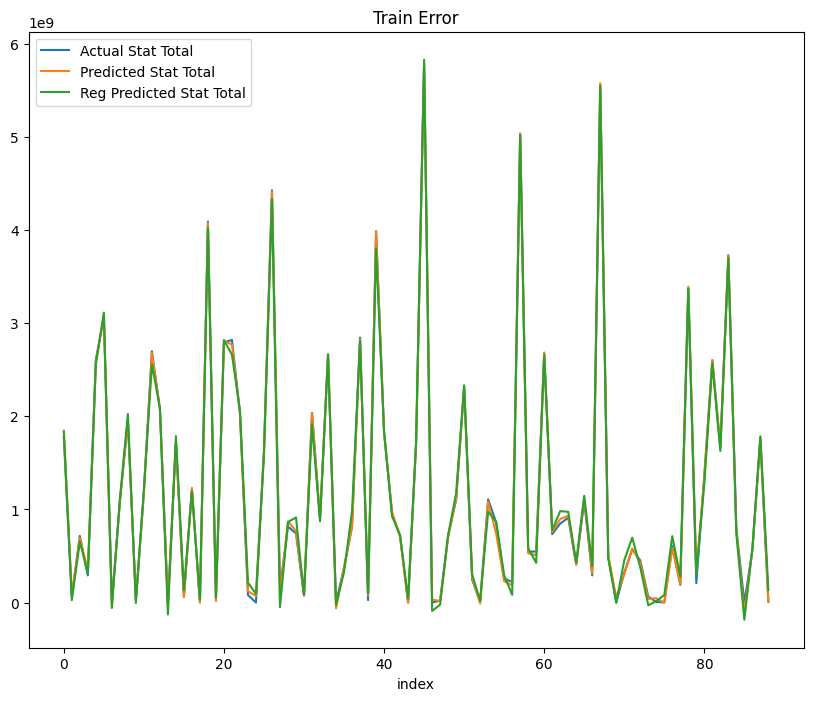

In [16]:
batch_erm_f, batch_erm_w = batch_erm_learner(train_features, train_labels, loss, epochs = 100000)
reg_f, reg_w = batch_reg_learner(train_features, train_labels, loss, _lambda = 1, epochs = 100000)

test_error = {'index' : [], 'Actual Stat Total' : [], 'Predicted Stat Total' : [], 'Reg Predicted Stat Total' : []}

for i, v in enumerate(test_features) :
  test_error['index'].append(i)
  act = lMean + lStd * test_labels[i]
  test_error['Actual Stat Total'].append(act)
  prd = lMean + lStd * batch_erm_f(v)
  test_error['Predicted Stat Total'].append(prd)
  rprd = lMean + lStd * reg_f(v)
  test_error['Reg Predicted Stat Total'].append(rprd)

test_error = pd.DataFrame(test_error)
print(test_error)
test_error.plot(figsize=(10, 8), x='index', y=['Actual Stat Total', 'Predicted Stat Total', 'Reg Predicted Stat Total'], title='Test Error')


train_error = {'index' : [], 'Actual Stat Total' : [], 'Predicted Stat Total' : [], 'Reg Predicted Stat Total' : []}

for i, v in enumerate(train_features) :
  train_error['index'].append(i)
  act = lMean + lStd * train_labels[i]
  train_error['Actual Stat Total'].append(act)
  prd = lMean + lStd * batch_erm_f(v)
  train_error['Predicted Stat Total'].append(prd)
  rprd = lMean + lStd * reg_f(v)
  train_error['Reg Predicted Stat Total'].append(rprd)

train_error = pd.DataFrame(train_error)
print(train_error)
train_error.plot(figsize=(10, 8), x='index', y=['Actual Stat Total', 'Predicted Stat Total', 'Reg Predicted Stat Total'], title='Train Error')





